In [3]:
import numpy as np
import scipy as sp
# impor binomial distribution
from scipy.stats import binom
import matplotlib.pyplot as plt

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

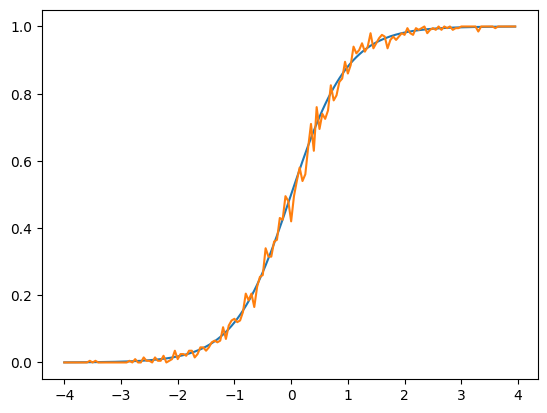

In [5]:
x = np.arange(-4, 4, 0.05)
y = np.tanh(x)
plt.plot(x, (y + 1) / 2)

# Given the y values, we want to use that as a win-rate for a binomial distribution
# at each x value, we want to sample 200 times from the binomial distribution
# and then plot a jagged line curve of the win-rate
n = 200
for i in range(len(x)):
    p = (y[i] + 1) / 2
    y[i] = binom.rvs(n, p) / n

plt.plot(x, y)

# plot the slope of the tanh function
# slope = np.gradient(np.tanh(x), x)
# plt.plot(x, slope)

In [6]:
class BiDirectionalLP:
    def __init__(self, ema_alpha = 0.1, p_theta = 0.1):
        """
        parser.add_argument("--ema-alpha", type=float, default=0.1,
                            help="smoothing value for ema in claculating learning progress (default: 0.1)")
        parser.add_argument("--p-theta", type=float, default=0.1,
                            help="parameter for reweighing learning progress (default: 0.1)")
        """
        self.n = n
        self.ema_alpha = ema_alpha
        self.p_theta = p_theta
        self.ema_tsr = None
        self.p_fast = None
        self.p_slow = None

    def learning_progress(self, y):
        # calculate the learning progress
        # normalize task success rates with random baseline rates
        random_success_rate = np.random.rand(y.shape[0])
        norm_y = np.maximum(y - random_success_rate, np.zeros(random_success_rate.shape)) / (1.0 - random_success_rate)
        # exponential mean average learning progress
        self.ema_tsr = y           * self.ema_alpha + self.ema_tsr * (1 - self.ema_alpha) if self.ema_tsr is not None else y
        self.p_fast  = norm_y      * self.ema_alpha + self.p_fast  * (1 - self.ema_alpha) if self.p_fast is not None else norm_y
        self.p_slow  = self.p_fast * self.ema_alpha + self.p_slow  * (1 - self.ema_alpha) if self.p_slow is not None else self.p_fast
        # NOTE: weighting to give more focus to tasks with lower success probabilities
        p_fast_reweigh = ((1 - self.p_theta) * self.p_fast) / (self.p_fast + self.p_theta * (1 - 2 * self.p_fast))
        p_slow_reweigh = ((1 - self.p_theta) * self.p_slow) / (self.p_slow + self.p_theta * (1 - 2 * self.p_slow))
        # learning progress is the change in probability to task success rate
        # NOTE: using bidirectional LP
        learning_progress = np.abs(p_fast_reweigh - p_slow_reweigh)
        return learning_progress

In [7]:
LP = BiDirectionalLP()

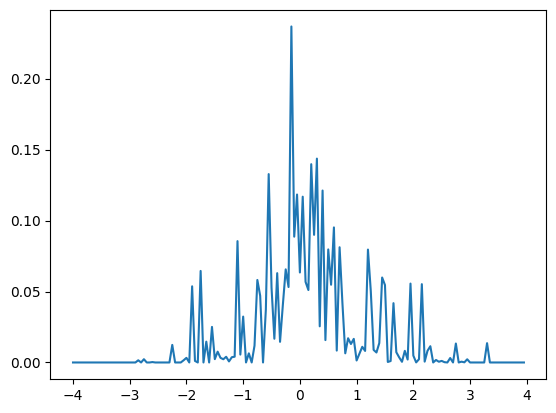

In [26]:
lp = LP.learning_progress(y)
plt.plot(x, lp)

In [27]:
# smooth the learning progress
def smooth(y):
    # smooth with a moving average
    window_size = 10
    y_smooth = np.zeros(y.shape[0])
    for i in range(window_size, y.shape[0] - window_size):
        y_smooth[i] = np.mean(y[i - window_size:i + window_size])
    return y_smooth

In [28]:
yy = smooth(lp)

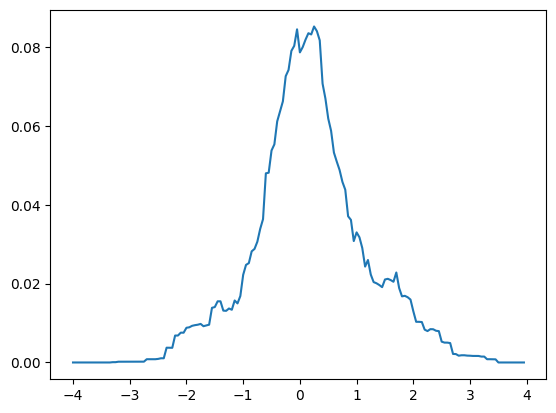

In [29]:
plt.plot(x, yy)